In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr


from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



import tensorflow as tf
from tensorflow import keras as tfk



2023-10-13 12:18:49.191234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
prices = pd.read_csv('Data_PCLab4_Stock_Price.csv')
volumes = pd.read_csv('Data_PCLab4_Stock_Volume.csv')

# make the date the index
prices.Date = pd.to_datetime(prices.Date)
prices.set_index('Date', inplace=True)

volumes.Date = pd.to_datetime(volumes.Date)
volumes.set_index('Date', inplace=True)

# Task 1

### volumes analysis

Average trading volume for AAPL:  58203317.4


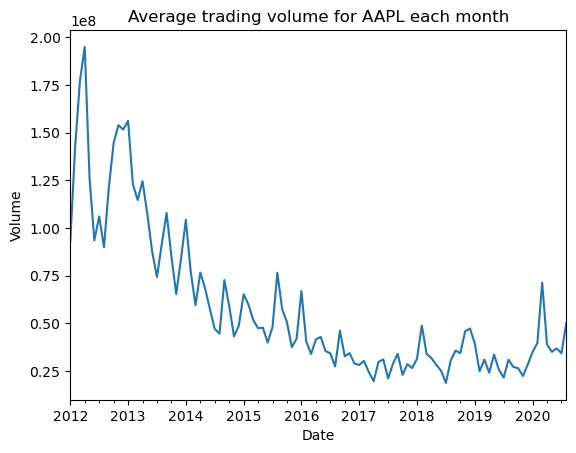

In [3]:
# print the average trading volume for AAPL
print('Average trading volume for AAPL: ', volumes['AAPL'].mean().round(1))

# plot the average trading volume for AAPL each month
volumes.resample('M').AAPL.mean().plot()
plt.title('Average trading volume for AAPL each month')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


Maximum trading volume for sp500:  9044690000


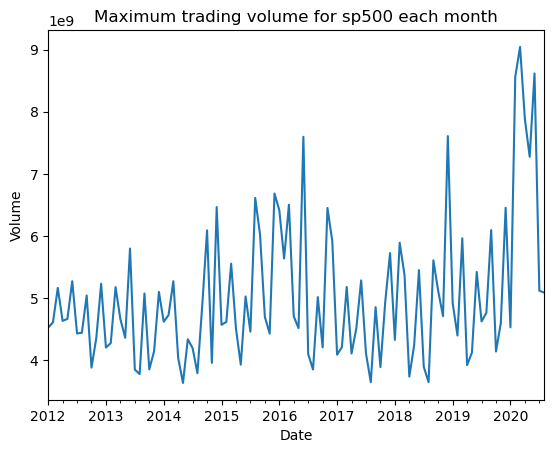

In [4]:
# print the maximum trading volume for sp500
print('Maximum trading volume for sp500: ', volumes['sp500'].max())

# plot the maximum trading volume for sp500 each month
volumes.resample('M').sp500.max().plot()
plt.title('Maximum trading volume for sp500 each month')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


### Volumes time series

array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>]], dtype=object)

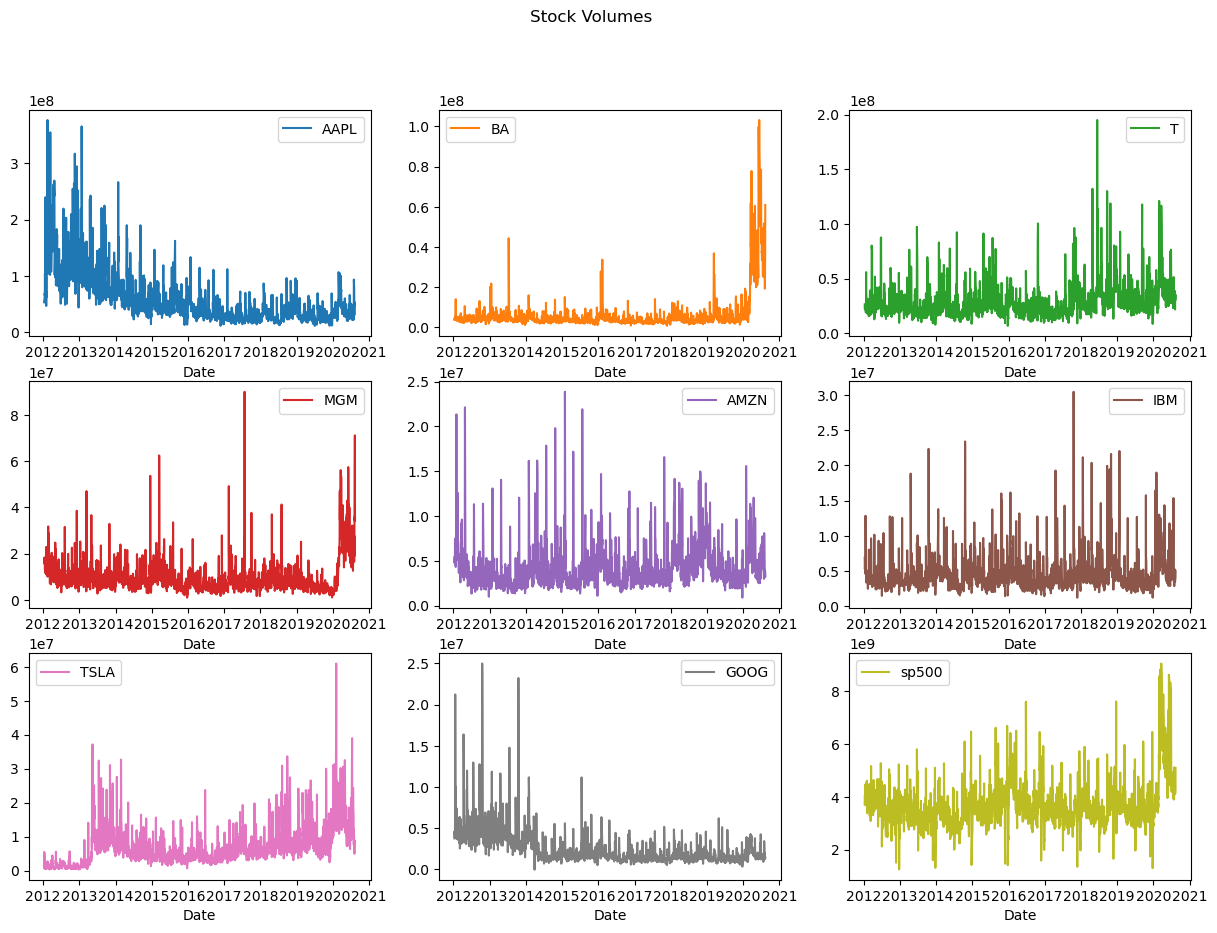

In [5]:

volumes.plot(figsize=(15,10), subplots=True, layout=(3,3), sharex=False, sharey=False, title='Stock Volumes')


array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>]], dtype=object)

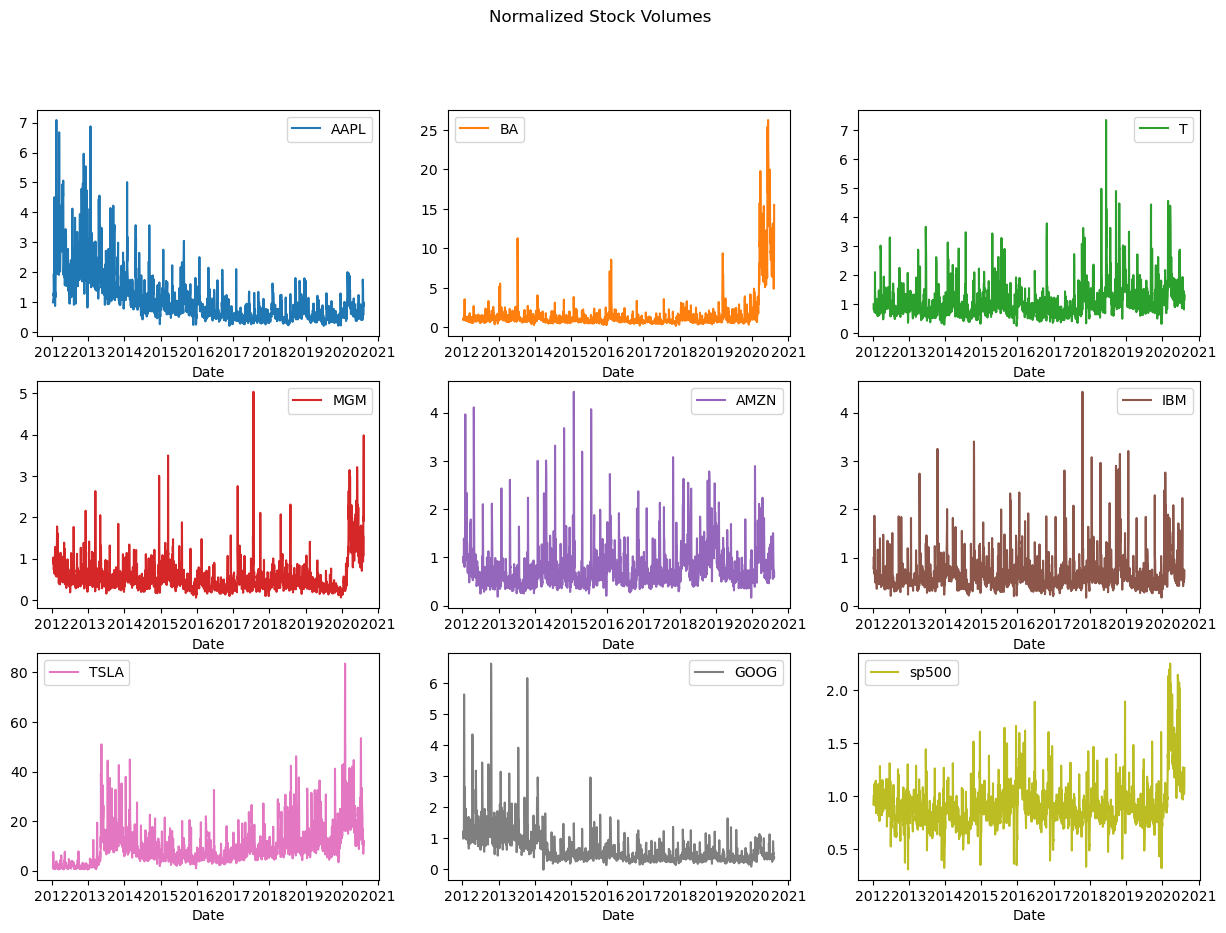

In [6]:
def normalize(df):
    return df / df.iloc[0, :]

volume_norm = normalize(volumes)

volume_norm.plot(figsize=(15,10), subplots=True, layout=(3,3), sharex=False, sharey=False, title='Normalized Stock Volumes')

### Correlation between the features

In [7]:
def daily_change(df):
    return df.pct_change(1)

price_daily = prices.apply(daily_change)[1:]
volume_daily = volumes.apply(daily_change)[1:]

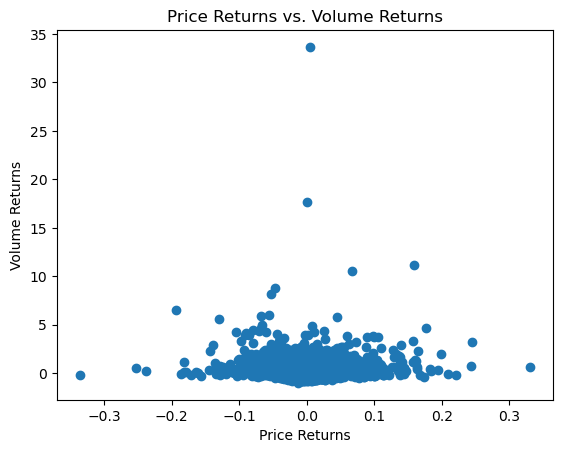

In [8]:
#give me correlation between daily and volume changes for each stock, and an aggregated measure
correlation = price_daily.corrwith(volume_daily).sort_values(ascending=True)

plt.scatter(price_daily, volume_daily)
plt.xlabel('Price Returns')
plt.ylabel('Volume Returns')
plt.title('Price Returns vs. Volume Returns')
plt.show()

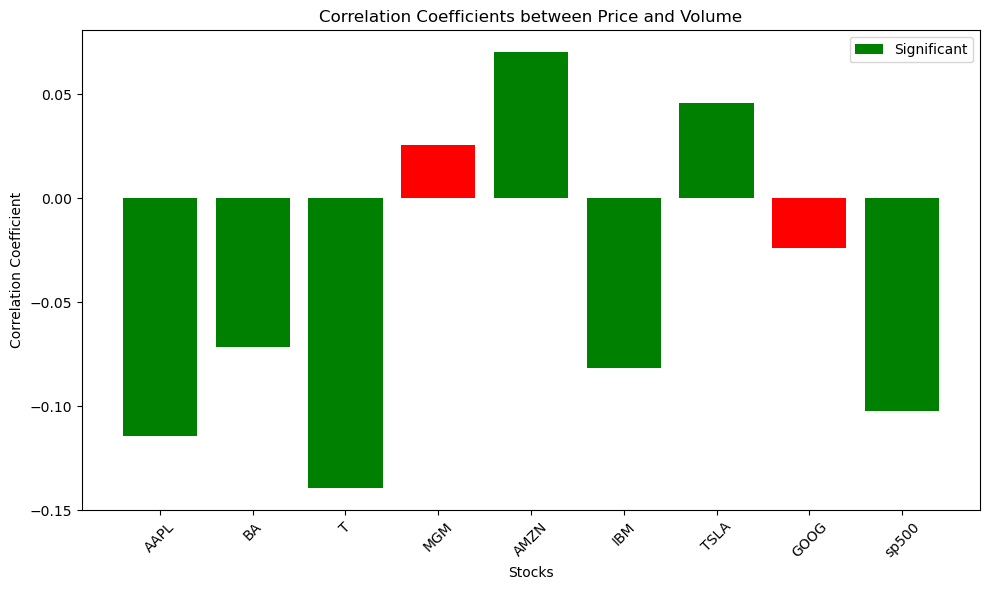

In [9]:
# Initialize empty lists to store the results
correlation_coefficients = []
p_values = []

# Iterate through the columns (stocks)
for stock in price_daily.columns:
    price_column = stock
    volume_column = stock

    # Calculate the correlation coefficient
    correlation_coefficient, p_value = pearsonr(price_daily[price_column], volume_daily[volume_column])

    # Append the results to the lists
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# Create an array for x-axis (stock names) and y-axis (correlation coefficients)
stocks = price_daily.columns
correlations = np.array(correlation_coefficients)

# Create a boolean mask to identify statistically significant correlations
significant_mask = np.array(p_values) < 0.05

# Create a list of colors based on the significant_mask
colors = np.where(significant_mask, 'g', 'r')

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(stocks, correlations, color=colors)
plt.xlabel('Stocks')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients between Price and Volume')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Add a legend for color coding
plt.legend(['Significant', 'Non-significant'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


Overall, the correlation between price returns and volume returns is not uniform across different stocks, highlighting the importance of individual stock analysis. Additionally, these results demonstrate that volume and price behavior can be influenced by various factors, such as investor sentiment, news events, or company-specific information.

# Task 2

First we create the datasets for the analysis. We will use the same stocks as in the previous task.
We want to have the price and volume data of the day and the previous day. 

In [10]:
# Update column levels for prices
prices.columns = pd.MultiIndex.from_product([prices.columns, ['price']])

# Update column levels for volumes
volumes.columns = pd.MultiIndex.from_product([volumes.columns, ['volume']])

df = pd.concat([prices, volumes], axis=1).sort_index(axis=1)
df.head()

AAPL                  AMZN                  BA           \
                price    volume       price   volume      price   volume   
Date                                                                       
2012-01-12  60.198570  53146800  175.929993  5385800  75.510002  3934500   
2012-01-13  59.972858  56505400  178.419998  4753500  74.599998  4641100   
2012-01-17  60.671429  60724300  181.660004  5644500  75.239998  3700100   
2012-01-18  61.301430  69197800  189.440002  7473500  75.059998  4189500   
2012-01-19  61.107143  65434600  194.449997  7096000  75.559998  5397300   

                  GOOG                   IBM             MGM            \
                 price    volume       price   volume  price    volume   
Date                                                                     
2012-01-12  313.644379   3764400  180.550003  6881000  12.13  17891100   
2012-01-13  311.328064   4631800  179.160004  5279200  12.35  16621800   
2012-01-17  313.116364   3832800  180.000000  6003400  12.25  15480800   
2012-01-18  315.273285   5544000  181.070007  4600600  12.73  18387600   
2012-01-19  318.590851  12657800  180.520004  8567200  12.80  14022900   

                    T                 TSLA                 sp500              
                price    volume      price   volume        price      volume  
Date                                                                          
2012-01-12  30.120001  26511100  28.250000   729300  1295.500000  4019890000  
2012-01-13  30.070000  22096800  22.790001  5500400  1289.089966  3692370000  
2012-01-17  30.250000  23500200  26.600000  4651600  1293.670044  4010490000  
2012-01-18  30.330000  22015000  26.809999  1260200  1308.040039  4096160000  
2012-01-19  30.420000  25524000  26.760000  1246300  1314.500000  4465890000

In [11]:
# for every stock, add a column at level 1 with the price_lag1 and volume_lag1
for stock in df.columns.levels[0]:
    df[stock, 'price_lag1'] = df[stock, 'price'].shift(1)
    df[stock, 'volume_lag1'] = df[stock, 'volume'].shift(1)

# rearrange the df such that for 'AAPL' I see price, volume, price_lag1, volume_lag1
df = df.reindex(sorted(df.columns), axis=1)

# drop the first row of the df
df = df.iloc[1:]

df.head()

AAPL                                          AMZN  \
                price price_lag1     volume volume_lag1       price   
Date                                                                  
2012-01-13  59.972858  60.198570   56505400  53146800.0  178.419998   
2012-01-17  60.671429  59.972858   60724300  56505400.0  181.660004   
2012-01-18  61.301430  60.671429   69197800  60724300.0  189.440002   
2012-01-19  61.107143  61.301430   65434600  69197800.0  194.449997   
2012-01-20  60.042858  61.107143  103493600  65434600.0  190.929993   

                                                    BA             ...  \
            price_lag1   volume volume_lag1      price price_lag1  ...   
Date                                                               ...   
2012-01-13  175.929993  4753500   5385800.0  74.599998  75.510002  ...   
2012-01-17  178.419998  5644500   4753500.0  75.239998  74.599998  ...   
2012-01-18  181.660004  7473500   5644500.0  75.059998  75.239998  ...   
2012-01-19  189.440002  7096000   7473500.0  75.559998  75.059998  ...   
2012-01-20  194.449997  5610300   7096000.0  75.519997  75.559998  ...   

                   T                   TSLA                                  \
              volume volume_lag1      price price_lag1   volume volume_lag1   
Date                                                                          
2012-01-13  22096800  26511100.0  22.790001  28.250000  5500400    729300.0   
2012-01-17  23500200  22096800.0  26.600000  22.790001  4651600   5500400.0   
2012-01-18  22015000  23500200.0  26.809999  26.600000  1260200   4651600.0   
2012-01-19  25524000  22015000.0  26.760000  26.809999  1246300   1260200.0   
2012-01-20  26445100  25524000.0  26.600000  26.760000   662300   1246300.0   

                  sp500                                         
                  price   price_lag1      volume   volume_lag1  
Date                                                            
2012-01-13  1289.089966  1295.500000  3692370000  4.019890e+09  
2012-01-17  1293.670044  1289.089966  4010490000  3.692370e+09  
2012-01-18  1308.040039  1293.670044  4096160000  4.010490e+09  
2012-01-19  1314.500000  1308.040039  4465890000  4.096160e+09  
2012-01-20  1315.380005  1314.500000  3912620000  4.465890e+09  

[5 rows x 36 columns]

In [12]:
#split the data into train and test, 75% training and 25% test
training_data, test_data = train_test_split(df, test_size=0.25, shuffle=False)
training_data.head()

AAPL                                          AMZN  \
                price price_lag1     volume volume_lag1       price   
Date                                                                  
2012-01-13  59.972858  60.198570   56505400  53146800.0  178.419998   
2012-01-17  60.671429  59.972858   60724300  56505400.0  181.660004   
2012-01-18  61.301430  60.671429   69197800  60724300.0  189.440002   
2012-01-19  61.107143  61.301430   65434600  69197800.0  194.449997   
2012-01-20  60.042858  61.107143  103493600  65434600.0  190.929993   

                                                    BA             ...  \
            price_lag1   volume volume_lag1      price price_lag1  ...   
Date                                                               ...   
2012-01-13  175.929993  4753500   5385800.0  74.599998  75.510002  ...   
2012-01-17  178.419998  5644500   4753500.0  75.239998  74.599998  ...   
2012-01-18  181.660004  7473500   5644500.0  75.059998  75.239998  ...   
2012-01-19  189.440002  7096000   7473500.0  75.559998  75.059998  ...   
2012-01-20  194.449997  5610300   7096000.0  75.519997  75.559998  ...   

                   T                   TSLA                                  \
              volume volume_lag1      price price_lag1   volume volume_lag1   
Date                                                                          
2012-01-13  22096800  26511100.0  22.790001  28.250000  5500400    729300.0   
2012-01-17  23500200  22096800.0  26.600000  22.790001  4651600   5500400.0   
2012-01-18  22015000  23500200.0  26.809999  26.600000  1260200   4651600.0   
2012-01-19  25524000  22015000.0  26.760000  26.809999  1246300   1260200.0   
2012-01-20  26445100  25524000.0  26.600000  26.760000   662300   1246300.0   

                  sp500                                         
                  price   price_lag1      volume   volume_lag1  
Date                                                            
2012-01-13  1289.089966  1295.500000  3692370000  4.019890e+09  
2012-01-17  1293.670044  1289.089966  4010490000  3.692370e+09  
2012-01-18  1308.040039  1293.670044  4096160000  4.010490e+09  
2012-01-19  1314.500000  1308.040039  4465890000  4.096160e+09  
2012-01-20  1315.380005  1314.500000  3912620000  4.465890e+09  

[5 rows x 36 columns]

Now we scale the data both of the price and the volume. We use the MinMaxScaler from sklearn.

In [13]:
scalers = {}  # to store scalers for each stock and measure

training_data_sc = training_data.copy()
test_data_sc = test_data.copy()


for stock in training_data.columns.levels[0]:
    for measure in ['price', 'price_lag1','volume', 'volume_lag1']:
        sc = MinMaxScaler(feature_range=(0, 1))
        training_data_sc[stock, measure] = sc.fit_transform(training_data_sc[stock, measure].values.reshape(-1, 1))
        scalers[(stock, measure)] = sc

for stock in test_data.columns.levels[0]:
    for measure in ['price', 'price_lag1','volume', 'volume_lag1']:
        sc = MinMaxScaler(feature_range=(0, 1))
        test_data_sc[stock, measure] = sc.fit_transform(test_data_sc[stock, measure].values.reshape(-1, 1))
        scalers[(stock, measure)] = sc


## OLS

In [14]:
# create a function that trains and predicts using OLS
def OLS_predict(training_data, test_data, scaler=dict()):

    # create a df to store the predictions
    predictions = pd.DataFrame(index=test_data.index, columns=test_data.columns.levels[0])

    # create a list to store the models
    models = []
    
    # for every stock create a model and predict the price on the test set
    for stock in training_data.columns.levels[0]:
        X_train = training_data[stock][['price_lag1', 'volume_lag1']]
        #print(X_train)
        y_train = training_data[stock, 'price']
        #print(y_train)
        X_test = test_data[stock][['price_lag1', 'volume_lag1']]
        
        # fit the model
        model = sm.OLS(y_train, X_train).fit()
        
        # predict the price
        predictions[stock] = model.predict(X_test)

        # invert the predictions
        predictions[stock] = scaler[(stock, 'price')].inverse_transform(predictions[stock].values.reshape(-1, 1))

        # store the model
        models.append(model)

    return predictions, models

predictions_ols, models_ols = OLS_predict(training_data_sc, test_data_sc, scalers)



## Ridge

In [15]:
from sklearn.linear_model import Ridge

def ridge_predict(training_data, test_data, scaler=dict(), alpha=1.0):
    # Create a DataFrame to store the predictions
    predictions = pd.DataFrame(index=test_data.index, columns=test_data.columns.levels[0])

    # Create a list to store the models
    models = []

    # For every stock, create a model and predict the price on the test set
    for stock in training_data.columns.levels[0]:
        X_train = training_data[stock][['price_lag1', 'volume_lag1']]
        y_train = training_data[stock, 'price']
        X_test = test_data[stock][['price_lag1', 'volume_lag1']]

        # Fit the Ridge model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict the price
        predictions[stock] = model.predict(X_test)

        # Invert the predictions
        predictions[stock] = scaler[(stock, 'price')].inverse_transform(predictions[stock].values.reshape(-1, 1))

        # Store the model
        models.append(model)

    return predictions, models

predictions_ridge, models_ridge = ridge_predict(training_data_sc, test_data_sc, scalers, alpha=0.5)


## Graphical Representation

In [16]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Assuming you have 'predictions_ridge', 'predictions_ols', and 'test_data' DataFrames

n_rows = len(predictions_ols.columns)
n_cols = 1  # Set the number of columns to 1 for vertical arrangement

fig = sp.make_subplots(rows=n_rows, cols=n_cols)

for idx, stock in enumerate(predictions_ols.columns):
    row = idx + 1  # Start from 1 for the first subplot

    # Create line chart for the financial data
    actual_trace = go.Scatter(x=test_data.index[1:], y=test_data[stock, 'price'][1:], mode='lines', name='Actual')
    predicted_ridge_trace = go.Scatter(x=predictions_ridge.index, y=predictions_ridge[stock], mode='lines', name='Predicted Ridge')
    predicted_ols_trace = go.Scatter(x=predictions_ols.index, y=predictions_ols[stock], mode='lines', name='Predicted OLS')

    # Add the subplot to the figure
    fig.append_trace(actual_trace, row, 1)
    fig.append_trace(predicted_ridge_trace, row, 1)
    fig.append_trace(predicted_ols_trace, row, 1)

    fig['layout']['xaxis' + str(idx + 1)].update(title="Date", tickfont=dict(color='white'), titlefont=dict(color='white'))
    fig['layout']['yaxis' + str(idx + 1)].update(title="Price", tickfont=dict(color='white'), titlefont=dict(color='white'))

    # Set the title of the subplot to the stock name
    subplot_title = stock
    fig.update_xaxes(title_text=subplot_title, row=row, col=1)


# Set the background color of the entire figure to black
fig['layout'].update(
    title="Financial Line Charts",  # Change the graph title here
    titlefont=dict(color='white'),  # Set the graph title color to white
    showlegend=False,
    paper_bgcolor='black',
    plot_bgcolor='black'
)

# Adjust the height of each subplot to make them one below the other
subplot_height = 400  # Adjust this value as needed
fig.update_layout(height=subplot_height * n_rows)

fig.show()


## Evaluation of the 2 models

### Rmse

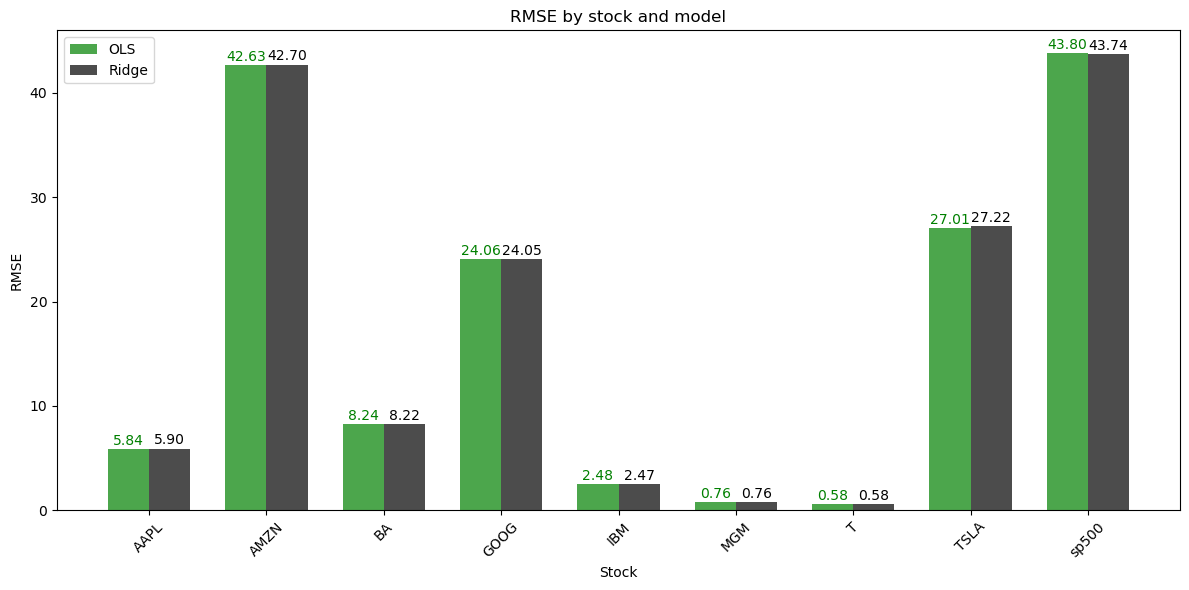

In [17]:
# Get the RMSE for each stock and for each method
rmse_values_OLS = []
rmse_values_Ridge = []

for stock in predictions_ols.columns:
    rmse_OLS = mean_squared_error(test_data[stock]['price'], predictions_ols[stock], squared=False)
    rmse_Ridge = mean_squared_error(test_data[stock]['price'], predictions_ridge[stock], squared=False)
    
    rmse_values_OLS.append(rmse_OLS)
    rmse_values_Ridge.append(rmse_Ridge)

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_ols.columns))

# Creating the bars
bar1 = ax.bar(index, rmse_values_OLS, bar_width, label='OLS', color='g', alpha=0.7)
bar2 = ax.bar(index + bar_width, rmse_values_Ridge, bar_width, label='Ridge', color='black', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by stock and model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_ols.columns, rotation=45)
ax.legend()

# Function to add labels on top of the bars
def add_labels(bars, color):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center',
                    color=color)

add_labels(bar1, 'g')  # Add labels for OLS bars with green color
add_labels(bar2, 'black')  # Add labels for Ridge bars with black color

# Display the plot
plt.tight_layout()
plt.show()


### Roos

First we compute the actual returns and the ones predicted by the models. 

In [18]:
predicted_returns_ols = predictions_ols.apply(daily_change)[1:]
predicted_returns_ridge = predictions_ridge.apply(daily_change)[1:]
actual_returns = test_data.xs('price', level=1, axis=1).apply(daily_change)[1:]

Then we define a function that computes the R2 Out of sample score.

In [19]:

def r2_oos(predicted_returns, actual_returns):
    # Calculate the numerator: sum of squared differences between actual and predicted returns
    numerator = np.sum((actual_returns - predicted_returns) ** 2)

    # Calculate the denominator: sum of squared actual returns
    denominator = np.sum(actual_returns ** 2)

    #print(numerator)
    #print(denominator)

    # Calculate the R-squared OOS metric
    r2_oos = 1 - (numerator / denominator)

    return r2_oos


In [20]:
# for each stock, calculate the r2_oos for OLS and Ridge

r2_oos_ols = []
r2_oos_ridge = []

for stock in predictions_ols.columns:
    r2_oos_ols.append(r2_oos(predicted_returns_ols[stock], actual_returns[stock]))
    r2_oos_ridge.append(r2_oos(predicted_returns_ridge[stock], actual_returns[stock]))


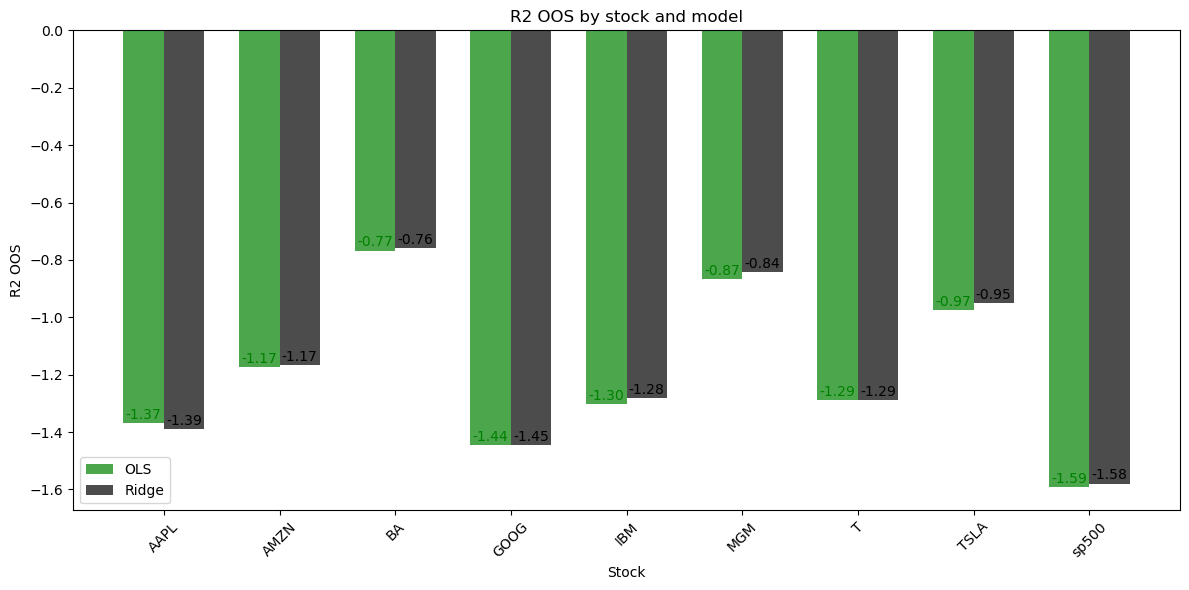

In [21]:
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_ols.columns))

# Creating the bars
bar1 = ax.bar(index, r2_oos_ols, bar_width, label='OLS', color='g', alpha=0.7)
bar2 = ax.bar(index + bar_width, r2_oos_ridge, bar_width, label='Ridge', color='black', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('R2 OOS')
ax.set_title('R2 OOS by stock and model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_ols.columns, rotation=45)
ax.legend()
        
add_labels(bar1, 'g')  # Add labels for OLS bars with green color
add_labels(bar2, 'black')  # Add labels for Ridge bars with black color

# Display the plot
plt.tight_layout()
plt.show()


The similarity between OLS and Ridge predictions and the actual prices may appear puzzling at first, but it aligns with the concept of price stickiness. OLS seemingly suggests that tomorrow's price will closely mirror today's (beta = 1), effectively amounting to a one-day price shift. To gain a deeper understanding, it's crucial to assess predicted returns against actual returns or implement the strategy. It's a reminder that performance metrics, such as those used by Gu et al., might not be ideal for this context, prompting the exploration of alternative metrics like the proportion of correct directional predictions.

Now we create a function able to compute the number of times the model predicted a price change with different sign with respect to the sign of the actual price change

### A new metric!

A good metric could be the one stating how many times the model predicted a price change with different sign with respect to the sign of the actual price change. This metric is a good one because it is able to capture the direction of the price change.

In [34]:
# function to compute the number of times the model wrongly predicted the direction of the price change
def compute_sign(predicted_returns, actual_returns):

    metrics  = {}
    for stock in actual_returns.columns:

        predicted_stock = predicted_returns[stock]
        true_stock = actual_returns[stock]
        

        
        error = []
        for t in range(len(predicted_stock)):
            if np.sign(predicted_stock.iloc[t]) != np.sign(true_stock.iloc[t]):
                error.append(1)
            else: 
                error.append(0)
        
        metrics[stock] = sum(error)/len(error)
    
    return metrics


In [23]:
# compute the above mentioed metric
sign_ols = compute_sign(predicted_returns_ols, actual_returns)
sign_ridge = compute_sign(predicted_returns_ridge, actual_returns)

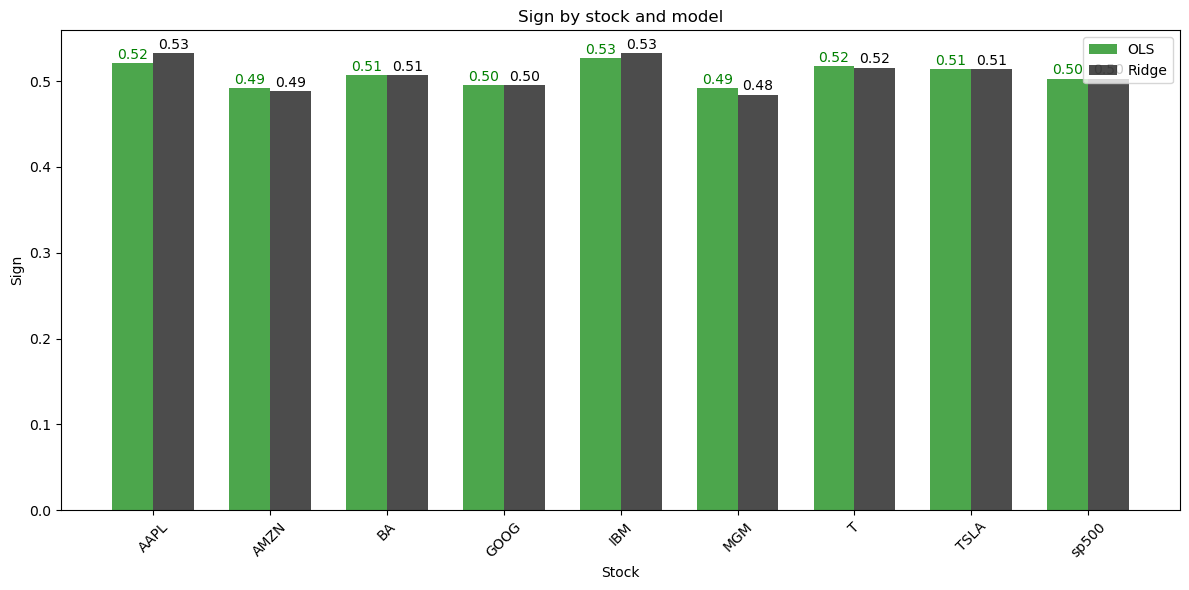

In [24]:
# plot the results
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_ols.columns))

# Creating the bars
bar1 = ax.bar(index, sign_ols.values(), bar_width, label='OLS', color='g', alpha=0.7)
bar2 = ax.bar(index + bar_width, sign_ridge.values(), bar_width, label='Ridge', color='black', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('Sign')
ax.set_title('Sign by stock and model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_ols.columns, rotation=45)
ax.legend()
        
add_labels(bar1, 'g')  # Add labels for OLS bars with green color
add_labels(bar2, 'black')  # Add labels for Ridge bars with black color

# Display the plot
plt.tight_layout()
plt.show()


As we can see from the last two plots, both OLS and Ridge obtained very good results in term go RMSE and Roos and poor results in terms of sign difference between predicted and actual price changes. 

These results seems reasonable. Indeed, both RMSE and Roos are metrics that take into account the difference between actual and predicted prices and, since both models make predictions based on the previous day's price, it seems reasonable that the predicted prices are very close to the actual values (generally stock prices do not face high daily variations). Also the the results of the last metric seem reasonable because the two models are very basic models that take as input just two variables (the lagged price and volume), thus the models are not able to correctly predict if the price of a stock will increase or decrease considering just those two variables.

# Task 2 Optional

It's time to try the same models with the value of the market

In [25]:
training_data_sc

AAPL                                       AMZN             \
               price price_lag1    volume volume_lag1     price price_lag1   
Date                                                                         
2012-01-13  0.030269   0.031902  0.123350    0.114150  0.000000   0.000000   
2012-01-17  0.035324   0.030269  0.134907    0.123350  0.002082   0.001609   
2012-01-18  0.039883   0.035324  0.158119    0.134907  0.007081   0.003702   
2012-01-19  0.038477   0.039883  0.147810    0.158119  0.010300   0.008728   
2012-01-20  0.030775   0.038477  0.252066    0.147810  0.008038   0.011964   
...              ...        ...       ...         ...       ...        ...   
2018-06-13  0.976265   0.987698  0.027838    0.014889  0.980776   0.983778   
2018-06-14  0.976988   0.976265  0.027761    0.027838  0.992984   0.987726   
2018-06-15  0.962805   0.976988  0.137632    0.027761  0.987914   1.000000   
2018-06-18  0.962081   0.962805  0.019200    0.137632  0.992939   0.994903   
2018-06-19  0.940010   0.962081  0.060546    0.019200  1.000000   0.999955   

                                        BA             ...         T  \
              volume volume_lag1     price price_lag1  ...    volume   
Date                                                   ...             
2012-01-13  0.164793    0.192439  0.024185   0.027175  ...  0.080939   
2012-01-17  0.203750    0.164793  0.026288   0.024185  ...  0.088395   
2012-01-18  0.283717    0.203750  0.025697   0.026288  ...  0.080505   
2012-01-19  0.267212    0.283717  0.027340   0.025697  ...  0.099148   
2012-01-20  0.202254    0.267212  0.027208   0.027340  ...  0.104041   
...              ...         ...       ...        ...  ...       ...   
2018-06-13  0.102445    0.055737  0.974665   0.996911  ...  1.000000   
2018-06-14  0.095752    0.102445  0.969966   0.974665  ...  0.434813   
2018-06-15  0.165847    0.095752  0.955047   0.969966  ...  0.569128   
2018-06-18  0.092835    0.165847  0.944729   0.955047  ...  0.381427   
2018-06-19  0.144532    0.092835  0.899974   0.944729  ...  0.427591   

                            TSLA                                      sp500  \
           volume_lag1     price price_lag1    volume volume_lag1     price   
Date                                                                          
2012-01-13    0.104392  0.000000   0.015074  0.139555    0.009902  0.006929   
2012-01-17    0.080939  0.010519   0.000000  0.116490    0.139555  0.009800   
2012-01-18    0.088395  0.011099   0.010519  0.024329    0.116490  0.018811   
2012-01-19    0.080505  0.010960   0.011099  0.023952    0.024329  0.022861   
2012-01-20    0.099148  0.010519   0.010960  0.008082    0.023952  0.023413   
...                ...       ...        ...       ...         ...       ...   
2018-06-13    0.279135  0.888959   0.883410  0.247422    0.597367  0.939028   
2018-06-14    1.000000  0.924685   0.888959  0.288489    0.247422  0.943329   
2018-06-15    0.434813  0.925927   0.924685  0.284883    0.288489  0.941555   
2018-06-18    0.569128  0.960879   0.925927  0.318169    0.284883  0.937849   
2018-06-19    0.381427  0.910411   0.960879  0.336884    0.318169  0.930852   

                                             
           price_lag1    volume volume_lag1  
Date                                         
2012-01-13   0.010948  0.384880    0.436471  
2012-01-17   0.006929  0.434990    0.384880  
2012-01-18   0.009800  0.448485    0.434990  
2012-01-19   0.018811  0.506724    0.448485  
2012-01-20   0.022861  0.419574    0.506724  
...               ...       ...         ...  
2018-06-13   0.946063  0.398562    0.338986  
2018-06-14   0.939028  0.358814    0.398562  
2018-06-15   0.943329  0.658398    0.358814  
2018-06-18   0.941555  0.321051    0.658398  
2018-06-19   0.937849  0.380013    0.321051  

[1618 rows x 36 columns]

## Introducing the market value of the previous day

In [26]:
def train_and_predict_ols_market(training_data_sc, test_data_sc):
   
   # create a df to store the predictions without the sp500
      predictions = pd.DataFrame(index=test_data_sc.index, columns=test_data_sc.columns.levels[0])
   
      # create a list to store the models
      models = []
      
      # for every stock create a model and predict the price on the test set
      for stock in training_data_sc.columns.levels[0]:
        # create the training and test set
            X_train = training_data_sc[stock][['price_lag1', 'volume_lag1']]
            # add to the training set the market
            X_train['market'] = training_data_sc['sp500']['price_lag1']
            y_train = training_data_sc[stock, 'price']

            X_test = test_data_sc[stock][['price_lag1', 'volume_lag1']]
            # add to the test set the market
            X_test['market'] = test_data_sc['sp500']['price_lag1']

            # fit the model
            model = sm.OLS(y_train, X_train).fit()

            # predict the price but not for the sp500
            predictions[stock] = model.predict(X_test)

            # invert the predictions
            predictions[stock] = scalers[(stock, 'price')].inverse_transform(predictions[stock].values.reshape(-1, 1))

            # store the model
            models.append(model)

      # remove the sp500 from the predictions
      predictions = predictions.drop(columns=['sp500'])
      

      return predictions, models

predictions_ols_market, models_ols_market = train_and_predict_ols_market(training_data_sc, test_data_sc)

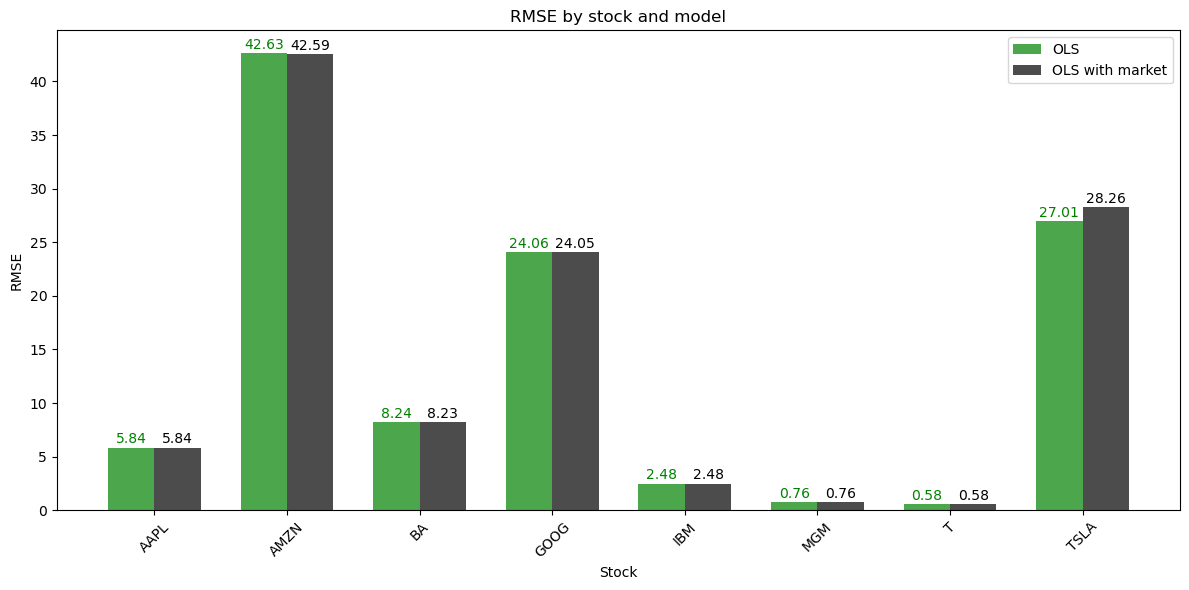

In [27]:
# Get the RMSE for each stock and for each method
rmse_values_OLS = []
rmse_values_market = []

for stock in predictions_ols.columns[:-1]:
    rmse_OLS = mean_squared_error(test_data[stock]['price'], predictions_ols[stock], squared=False)
    rmse_market = mean_squared_error(test_data[stock]['price'], predictions_ols_market[stock], squared=False)
    
    rmse_values_OLS.append(rmse_OLS)
    rmse_values_market.append(rmse_market)

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_ols.columns[:-1]))

# Creating the bars
bar1 = ax.bar(index, rmse_values_OLS, bar_width, label='OLS', color='g', alpha=0.7)
bar2 = ax.bar(index + bar_width, rmse_values_market, bar_width, label='OLS with market', color='black', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by stock and model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_ols.columns[:-1], rotation=45)
ax.legend()
        
add_labels(bar1, 'g')  # Add labels for OLS bars with green color
add_labels(bar2, 'black')  # Add labels for Ridge bars with black color

# Display the plot
plt.tight_layout()
plt.show()




In [28]:
predicted_returns_ols_market = predictions_ols_market.apply(daily_change)[1:]
actual_returns_1 = actual_returns.drop(columns=['sp500'])

/var/folders/rw/rz6fjf7d15l_1tmxpdktk2qw0000gn/T/ipykernel_23295/574461119.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



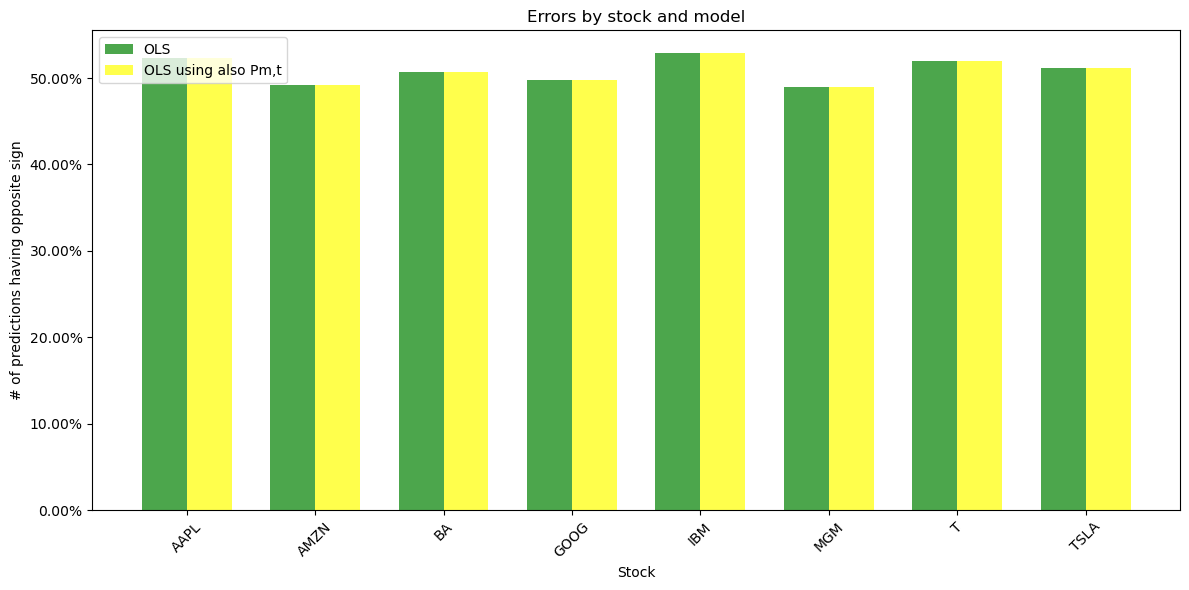

In [44]:
metrics_market = compute_sign(predicted_returns_ols_market, actual_returns_1)

#Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(metrics_market))

# Creating the bars
bar1 = ax.bar(index, metrics_market.values(), bar_width, label='OLS', color='g', alpha=0.7)
bar2 = ax.bar([i + bar_width for i in index], metrics_market.values(), bar_width, label='OLS using also Pm,t', color='yellow', alpha=0.7)

# Format the plot
plt.xlabel('Stock')
plt.ylabel('# of predictions having opposite sign')
plt.title('Errors by stock and model')
plt.xticks([i + bar_width / 2 for i in index], metrics_market.keys(), rotation=45)
# show the y axis tick marks as percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Adding to the models another input (in this case the lagged price of the market) does not seem to improve their performance

# Task 3

## Feedforward Neural Network

<img src="image-20231010-172339.png" width="" align="" />

In [47]:
# pick volume lag 1 and price lag 1 as features
X_train = training_data_sc.xs('volume_lag1', level=1, axis=1)
X_train['price_lag1'] = training_data_sc.xs('price_lag1', level=1, axis=1)

TypeError: list keys are not supported in xs, pass a tuple instead

In [48]:
def train_and_predict_nn(training_data_sc, test_data_sc):
    # Dictionary to store models
    new_df = pd.DataFrame()

    for stock in training_data_sc.columns.levels[0]:
        extract = training_data_sc.shift(1).dropna()[stock][['price', 'volume']].reset_index(drop=True).rename(columns={'price':'price_lag1', 'volume':'volume_lag1'})
        price = training_data_sc[stock][['price']][1:].reset_index(drop=True)
        extract = pd.concat([extract,price],axis=1)
        new_df=pd.concat([new_df, extract],axis=0)


    # Generate predictor matrix (X) and response vector (y) for training
    X_train = new_df[['price_lag1', 'volume_lag1']]
    y_train = new_df['price']  
        
    # Create the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),  # Input layer
        tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
        tf.keras.layers.Dense(1)  # Output layer
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)  # setting verbose=0 to suppress the training logs
    
    
    
    new_df = pd.DataFrame()

    for stock in test_data_sc.columns.levels[0]:
        extract = test_data_sc.shift(1).dropna()[stock][['price', 'volume']].reset_index(drop=True).rename(columns={'price':'price_lag1', 'volume':'volume_lag1'})
        price = test_data_sc[stock][['price']][1:].reset_index(drop=True)
        extract = pd.concat([extract,price],axis=1)
        new_df=pd.concat([new_df, extract],axis=0)


    # 3. Predict using this single model
    predictions_sc = pd.DataFrame(index=test_data_sc.index[1:], columns=test_data_sc.columns)
    for stock in test_data_sc.columns.levels[0]:
        X_test = test_data_sc[stock][['price', 'volume']].shift(1).dropna()
        X_test = np.array(X_test)  # Convert X_test to a numpy array
        predictions_stock = model.predict(X_test)
        predictions_sc[stock] = predictions_stock.flatten()

        
    # Remove volume column from predictions
    predictions_sc = predictions_sc.xs('price', axis=1, level=1).dropna()

    # Inverse transform the predictions (assuming you have `scalers` dictionary like in OLS code)
    predictions = pd.DataFrame(index=predictions_sc.index, columns=predictions_sc.columns)
    for stock in predictions_sc.columns:
        predictions[stock] = scalers[(stock, 'price')].inverse_transform(predictions_sc[stock].values.reshape(-1, 1)).flatten()

    return predictions


In [49]:
predictions_FNN = train_and_predict_nn(training_data_sc, test_data_sc)

predicted_returns_FNN = predictions_FNN.apply(daily_change)[1:]

17/17 [==============================] - 0s 605us/step


## Random Forest

In [57]:
def train_and_predict_rf(training_data_sc, test_data_sc):
    # Dictionary to store models
    models = {}
    
    # Train Random Forest models for each stock in the training data
    for stock in training_data_sc.columns.levels[0]:
        X_train_df = training_data_sc[stock][['price', 'volume']].shift(1).dropna()
        y_train = training_data_sc[stock]['price'].loc[X_train_df.index].values
        X_train = X_train_df.values

        # Create the Random Forest model
        model = RandomForestRegressor(n_estimators=100)  # Default number of trees is 100
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Store the trained model
        models[stock] = model
    
    # Use the models to predict the price for each stock in the test data
    predictions_sc = pd.DataFrame(index=test_data_sc.index[1:], columns=test_data_sc.columns)
    for stock in test_data_sc.columns.levels[0]:
        X_test_df = test_data_sc[stock][['price', 'volume']].shift(1).dropna()
        X_test = X_test_df.values

        predictions_sc[stock, 'price'] = models[stock].predict(X_test)
    
    # Remove volume column from predictions
    predictions_sc = predictions_sc.xs('price', axis=1, level=1).dropna()

    # Inverse transform the predictions (assuming you have `scalers` dictionary like in OLS code)
    predictions = pd.DataFrame(index=predictions_sc.index, columns=predictions_sc.columns)
    for stock in predictions_sc.columns:
        predictions[stock] = scalers[(stock, 'price')].inverse_transform(predictions_sc[stock].values.reshape(-1, 1)).flatten()

    return predictions


In [58]:
predictions_RF = train_and_predict_rf(training_data_sc, test_data_sc)

predicted_returns_RF = predictions_RF.apply(daily_change)[1:]

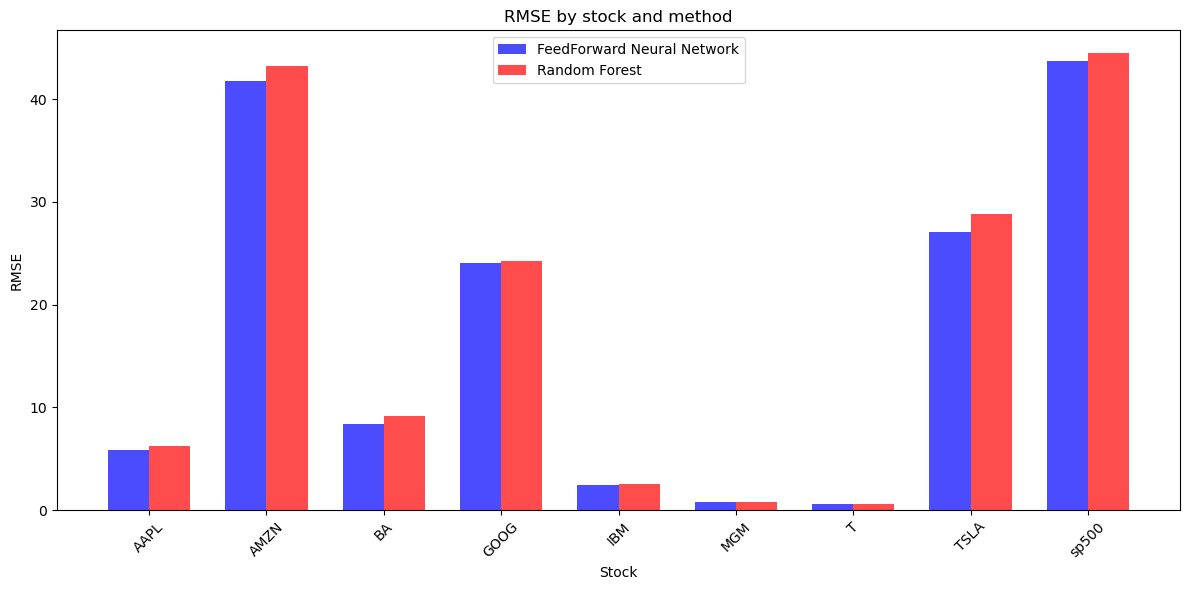

In [59]:
# Get the RMSE for each stock and for each method
rmse_values_FNN = []
rmse_values_RF = []

for stock in predictions_RF.columns:
    rmse_FNN = mean_squared_error(test_data[stock, 'price'][1:], predictions_FNN[stock], squared=False)
    rmse_RF = mean_squared_error(test_data[stock, 'price'][1:], predictions_RF[stock], squared=False)

    rmse_values_FNN.append(rmse_FNN)
    rmse_values_RF.append(rmse_RF)

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_RF.columns))

# Creating the bars
bar1 = ax.bar(index, rmse_values_FNN, bar_width, label='FeedForward Neural Network', color='b', alpha=0.7)
bar2 = ax.bar(index + bar_width, rmse_values_RF, bar_width, label='Random Forest', color='r', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by stock and method')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_RF.columns, rotation=45)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


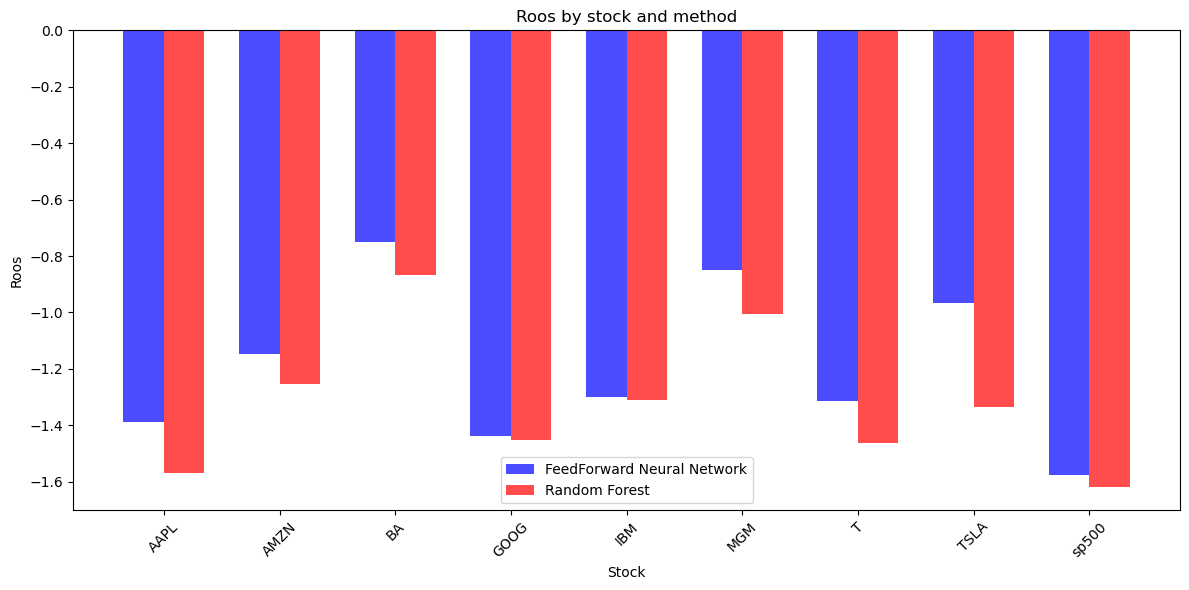

In [71]:
r2_oos_RF = r2_oos(predicted_returns_RF, actual_returns)
r2_oos_FNN = r2_oos(predicted_returns_FNN, actual_returns)

# plot the Roos for each stock and for each method uing the style of previous graph
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(predictions_RF.columns))

# Creating the bars
bar1 = ax.bar(index, r2_oos_FNN, bar_width, label='FeedForward Neural Network', color='b', alpha=0.7)
bar2 = ax.bar(index + bar_width, r2_oos_RF, bar_width, label='Random Forest', color='r', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('Roos')
ax.set_title('Roos by stock and method')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(predictions_RF.columns, rotation=45)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/rw/rz6fjf7d15l_1tmxpdktk2qw0000gn/T/ipykernel_23295/2478337083.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



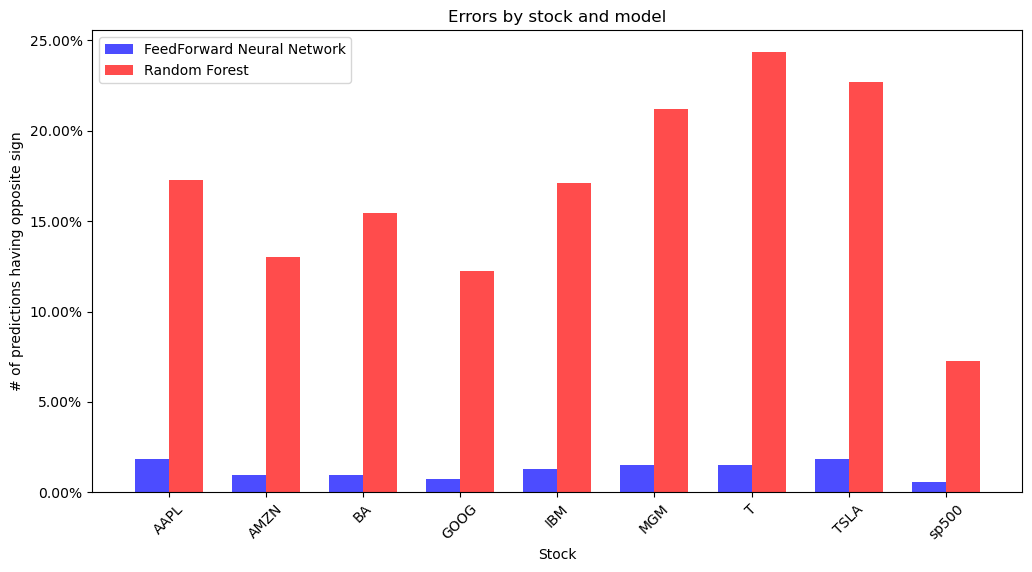

In [76]:
sign_RF = compute_sign(predicted_returns_RF, actual_returns)
sign_FNN = compute_sign(predicted_returns_FNN, actual_returns)

# plot metrics_FNN against metrics_RF
#Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(sign_RF))

# Creating the bars
bar1 = ax.bar(index, sign_FNN.values(), bar_width, label='FeedForward Neural Network', color='b', alpha=0.7)
bar2 = ax.bar([i + bar_width for i in index], sign_RF.values(), bar_width, label='Random Forest', color='r', alpha=0.7)

# Format the plot
plt.xlabel('Stock')
plt.ylabel('# of predictions having opposite sign')
plt.title('Errors by stock and model')
plt.xticks([i + bar_width / 2 for i in index], sign_RF.keys(), rotation=45)

# show the y axis tick marks as percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.legend()



## Comment 1

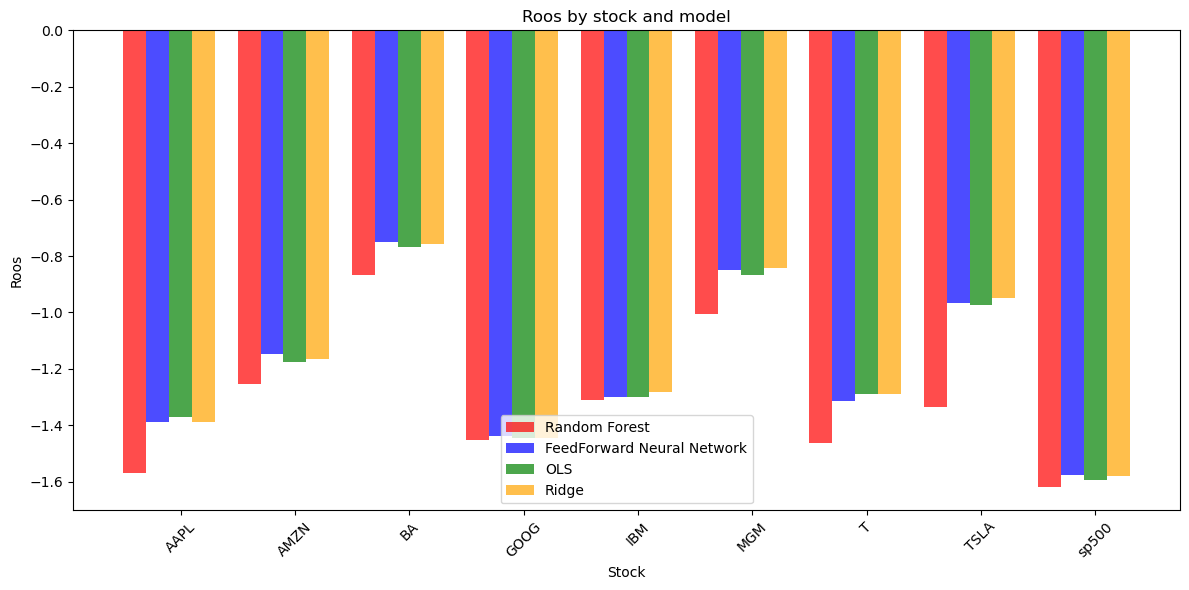

In [79]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.2  # Reduced bar width to fit more models on the plot
index = np.arange(len(predictions_ols.columns))

# Creating the bars for Random Forest, FNN, Roos_ols, and Roos_ridge
bar1 = ax.bar(index, r2_oos_RF, bar_width, label='Random Forest', color='r', alpha=0.7)
bar2 = ax.bar(index + bar_width, r2_oos_FNN, bar_width, label='FeedForward Neural Network', color='b', alpha=0.7)
bar3 = ax.bar(index + 2*bar_width, r2_oos_ols, bar_width, label='OLS', color='g', alpha=0.7)
bar4 = ax.bar(index + 3*bar_width, r2_oos_ridge, bar_width, label='Ridge', color='orange', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('Roos')
ax.set_title('Roos by stock and model')
ax.set_xticks(index + 2*bar_width)  # Adjust the tick positions
ax.set_xticklabels(predictions_ols.columns, rotation=45)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/rw/rz6fjf7d15l_1tmxpdktk2qw0000gn/T/ipykernel_23295/2891572191.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



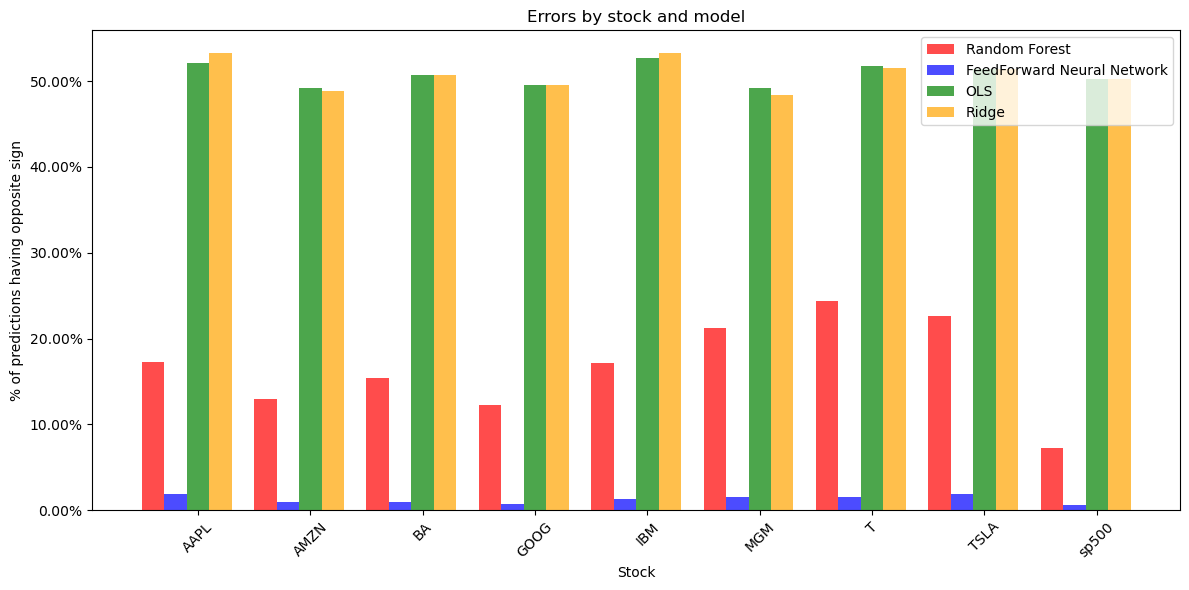

In [80]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bar width and positions
bar_width = 0.2  # Reduced bar width to fit more models on the plot
index = np.arange(len(predictions_ols.columns))

# Creating the bars for Random Forest, FNN, Roos_ols, and Roos_ridge
bar1 = ax.bar(index, sign_RF.values(), bar_width, label='Random Forest', color='r', alpha=0.7)
bar2 = ax.bar(index + bar_width, sign_FNN.values(), bar_width, label='FeedForward Neural Network', color='b', alpha=0.7)
bar3 = ax.bar(index + 2*bar_width, sign_ols.values(), bar_width, label='OLS', color='g', alpha=0.7)
bar4 = ax.bar(index + 3*bar_width, sign_ridge.values(), bar_width, label='Ridge', color='orange', alpha=0.7)

# Labeling and plotting
ax.set_xlabel('Stock')
ax.set_ylabel('% of predictions having opposite sign')
ax.set_title('Errors by stock and model')
ax.set_xticks(index + 2*bar_width)  # Adjust the tick positions
ax.set_xticklabels(predictions_ols.columns, rotation=45)
ax.legend()

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# Display the plot
plt.tight_layout()
plt.show()

Looking at the RMSE, Roos, and the sign metric we can see the the simpler methods performed a bit better. We think this is due to the fact that we are only using two variables and models like random forests and neural networks outperform OLS in settings with a high number of inputs. If we look at 

We think we cannot make a useful comparison between our results and the results of the paper because the model used in the paper take as input a lot of variables (about 90) while our models take just 2/3 inputs.

## Comment 2

# Task 4 Optional

In [ ]:
tickers

['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA']

In [ ]:
for stock in tickers:
    df[stock, 'price_lag1'] = df[stock]['price'].shift(1)
    df[stock, 'volume_lag1'] = df[stock]['volume'].shift(1)

df = df.sort_index(axis=1, level=0)


scalers={}
df1 = df.copy()
for stock in tickers:
    for measure in ['price','price_lag1', 'volume', 'volume_lag1']:
        sc = MinMaxScaler(feature_range=(0, 1))
        df1[stock, measure] = sc.fit_transform(df[stock, measure].values.reshape(-1, 1))
        scalers[(stock, measure)] = sc
df1.head()
del df1['sp500']

In [ ]:
def investment_strategy(df, df1, model_ridge, scalers, wealth, top_stocks):   
    

    for day in df1.index[1:]:
        pred_returns = {}
        actual_returns  = {}

        for stock in df1.columns.levels[0]:
            if stock == 'sp500':
                continue
            
            regressors = df1[stock].loc[day, ['price_lag1', 'volume_lag1']]
            regressors = pd.DataFrame(regressors).T
            price_pred = model_ridge.predict(regressors)
            

            price_pred = scalers[(stock, 'price')].inverse_transform(price_pred.reshape(-1, 1))

            """print(stock)
            print(f"price_pred is: \t {price_pred}")
            print(f"real price is: \t {df[stock].loc[day, 'price']}")
            print((price_pred - df[stock].loc[day, 'price_lag1']) / df[stock].loc[day, 'price_lag1'])"""
            
            pred_returns[stock] = (price_pred - df[stock].loc[day, 'price_lag1']) / df[stock].loc[day, 'price_lag1']
            actual_returns[stock] = (df[stock].loc[day, 'price'] - df[stock].loc[day, 'price_lag1']) / df[stock].loc[day, 'price_lag1']
        
        pred_returns = dict(sorted(pred_returns.items(), key=lambda item: item[1], reverse=True))
        selected_stock = list(pred_returns.keys())[:top_stocks]
        portfolio = [wealth/top_stocks for i in range(top_stocks)]

        for pos, stock in enumerate(selected_stock):
            portfolio[pos] = portfolio[pos] * (1 + actual_returns[stock])
        
        wealth = sum(portfolio)

    return wealth

investment_strategy(df, df1, model_ridge, scalers, 100, 4)

1298.8807457118235

In [ ]:
def investment_strategy(df, df1, model_ridge, scalers, wealth, top_stocks):
    wealth_history = []

    for day in df1.index[1:]:
        pred_returns = {}
        actual_returns = {}

        for stock in df1.columns.levels[0]:
            if stock == 'sp500':
                continue

            regressors = df1[stock].loc[day, ['price_lag1', 'volume_lag1']]
            regressors = pd.DataFrame(regressors).T
            price_pred = model_ridge.predict(regressors)

            price_pred = scalers[(stock, 'price')].inverse_transform(price_pred.reshape(-1, 1))

            pred_price_lag1 = df[stock].at[day, 'price_lag1']
            current_price = df[stock].at[day, 'price']

            pred_returns[stock] = (price_pred - pred_price_lag1) / pred_price_lag1
            actual_returns[stock] = (current_price - pred_price_lag1) / pred_price_lag1

        pred_returns = dict(sorted(pred_returns.items(), key=lambda item: item[1], reverse=True))
        selected_stock = list(pred_returns.keys())[:top_stocks]
        portfolio = [wealth / top_stocks for _ in range(top_stocks)]

        portfolio = [portfolio[i] * (1 + actual_returns[stock]) for i, stock in enumerate(selected_stock)]
        wealth = sum(portfolio)
        wealth_history.append(wealth)

    return wealth, wealth_history

final_wealth, wealth_history = investment_strategy(df, df1, model_ridge, scalers, 100, 4)
print("Final Wealth:", final_wealth)
print("Wealth History:", wealth_history)

Final Wealth: 1298.8807457118235
Wealth History: [95.12695475336591, 100.01565207169332, 101.48371729807477, 102.19596476910472, 101.12220373591896, 101.06723130875844, 101.34028509982056, 103.69339321054389, 105.06219099579836, 105.58615549545192, 105.56716489304434, 105.64471078847353, 104.48021391663382, 105.28753388194691, 107.5896102694339, 107.44118648506532, 107.61506374502765, 108.62793488049721, 110.20536855941744, 108.70632783827887, 110.40264696111458, 112.47190171925894, 111.05155532435933, 111.12293858231129, 112.18638495065838, 112.62132509094864, 112.1607341629831, 112.25800319224021, 112.06657786348407, 111.73138253084748, 113.20791142183697, 112.53273677964563, 113.58367220263949, 113.13058220046653, 112.14335012302871, 110.97824204254937, 111.7867924340644, 113.17527875355708, 113.93378952309153, 115.30866847787682, 116.68022247248736, 117.12948646539263, 117.11567800915654, 117.39302125596058, 118.04145409016147, 119.2446703186416, 119.09189357255941, 117.97186897724

In [ ]:
wealth_history = pd.DataFrame(wealth_history,index = df.index[1:])

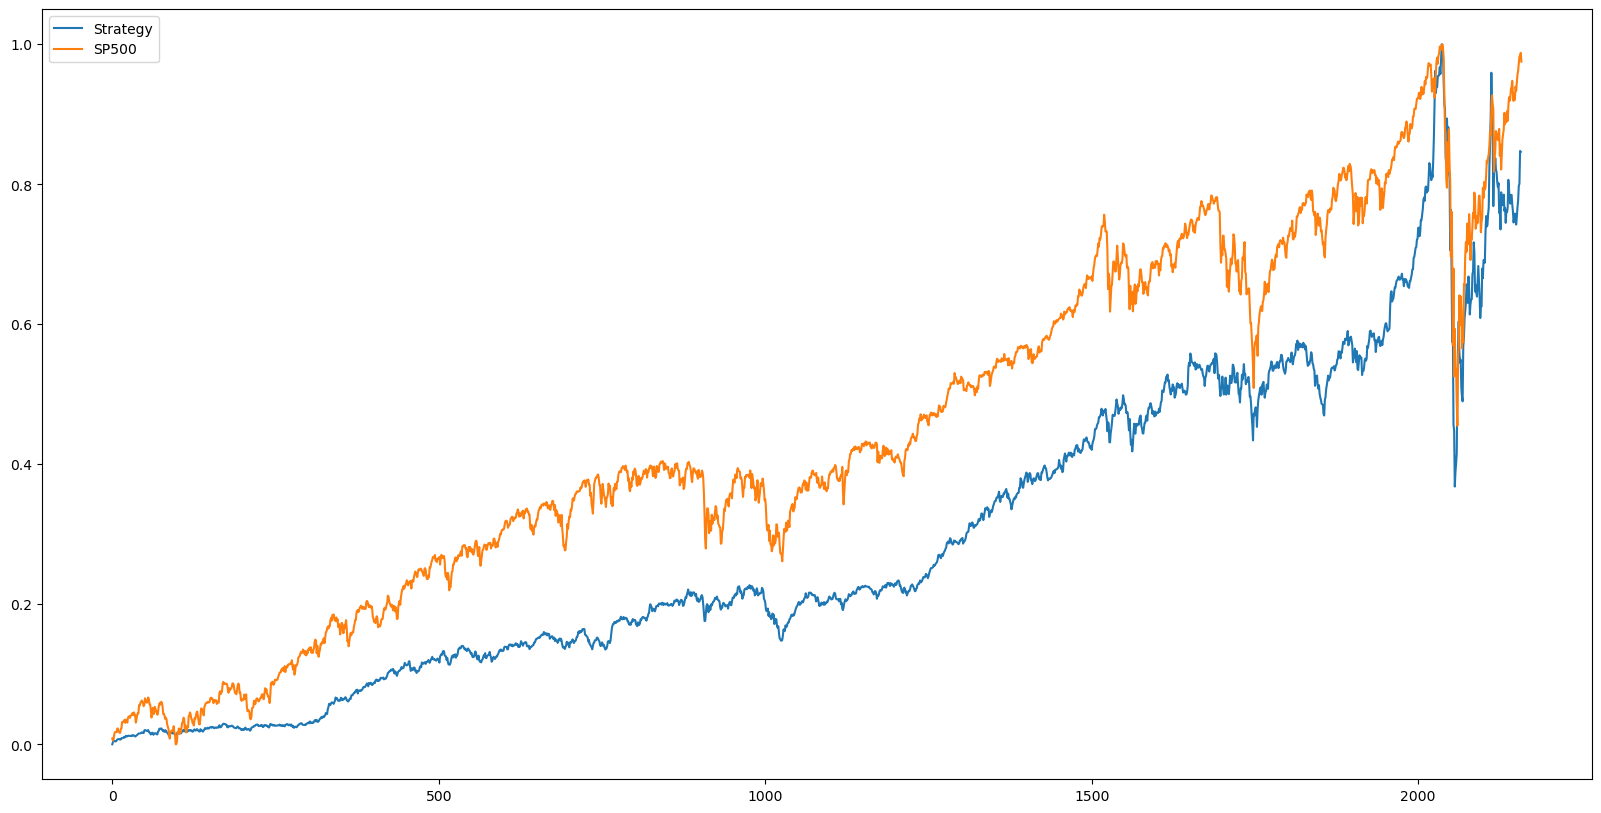

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
normalized_wealth_history = scaler.fit_transform(np.array(wealth_history).reshape(-1, 1))
normalized_sp500 = scaler.fit_transform(np.array(df['sp500']['price']).reshape(-1, 1))

# Plot the normalized data
plt.figure(figsize=(20, 10))
plt.plot(normalized_wealth_history, label='Strategy')
plt.plot(normalized_sp500, label='SP500')
plt.legend()
plt.show()
#add x axis from wealth_history.index[1:]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8890790-c7a3-42d0-8ce4-3014946c2cc2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>